# A/B Testing 

https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data

##### Disclaimer: While analyzing this A/B test, I observed a severe imbalance between the treatment and control groups (96% vs. 4% of users). This raises concerns about the validity of randomization, the statistical power of the smaller control group, and potential bias if the assignment was not truly random.
##### If I had access to pre‑test metrics, I could verify that both groups were similar before the test began — and, if necessary, re‑sample or weight observations to create matched, balanced groups (e.g., via propensity scores or stratified bootstrap). Additionally, I couldn't verify whether data anomalies represent real user behavior without additional contextual information.

This project analyzes user behavior data from a randomized marketing A/B test campaign. The dataset contains individual-level ad exposure and conversion outcomes, segmented into an experimental group (who were shown ads) and a control group (who saw only neutral public service announcements).  

The goal of this analysis is to evaluate the effectiveness of the advertising campaign by comparing conversion rates and user behavior between the two groups. Additionally, the analysis explores how engagement and response rates vary across user segments defined by ad frequency, time of day, and day of week.  

To assess whether observed differences between groups are statistically significant, classical hypothesis testing methods were applied, including independent two-sample t-tests and confidence intervals. These tools help quantify the likelihood that differences in conversion rates and user activity metrics arose by chance, and to estimate the range of plausible true effects.  

A/B testing is a foundational technique in digital marketing, as it allows businesses to isolate the causal impact of campaigns while controlling for confounding factors. By identifying which user segments respond most to ads, companies can optimize targeting strategies, improve ad efficiency, and maximize return on investment (ROI).

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('marketing_AB.csv')

In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [14]:
df.shape, df['test group'].value_counts()

((588101, 6),
 test group
 ad     564577
 psa     23524
 Name: count, dtype: int64)

In [21]:
df[df['total ads']<100].shape, df[df['total ads']>=100].shape, 23469/564632

((564632, 6), (23469, 6), 0.04156512560393318)

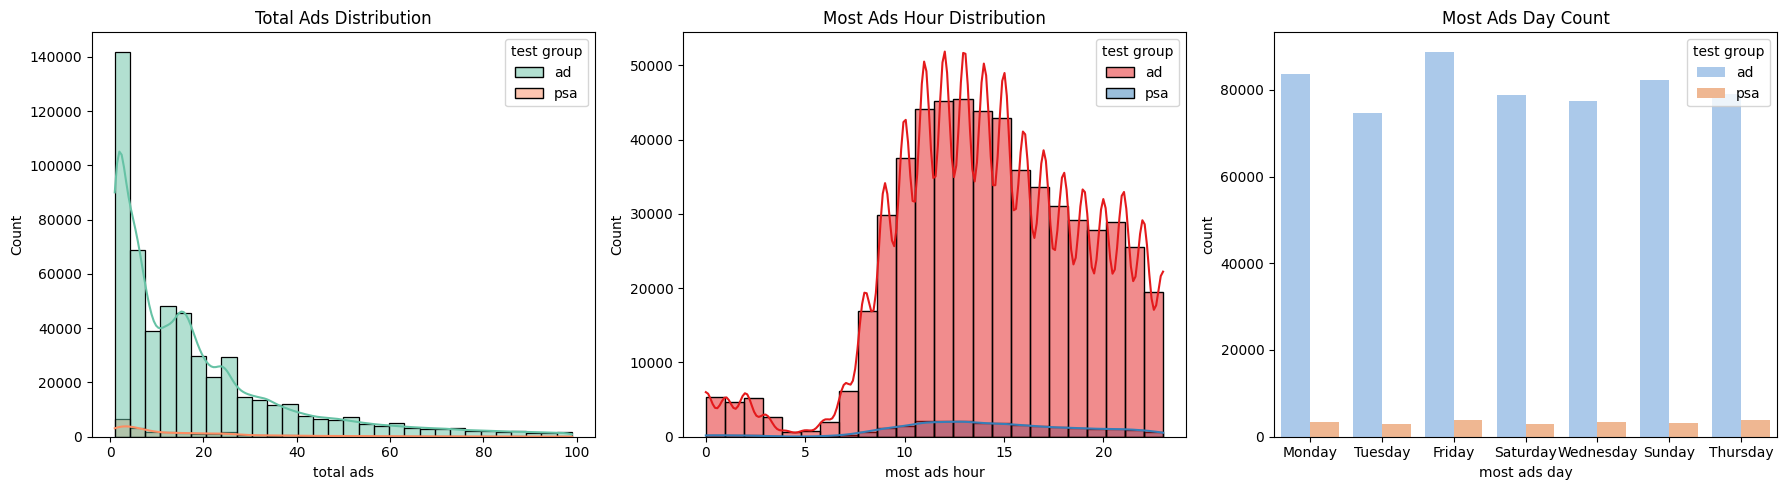

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data=df[df['total ads']<100], x='total ads', hue='test group', kde=True, bins=30, palette='Set2', ax=axes[0])
axes[0].set_title("Total Ads Distribution")

sns.histplot(data=df, x='most ads hour', hue='test group', kde=True, bins=24, palette='Set1', ax=axes[1])
axes[1].set_title("Most Ads Hour Distribution")

sns.countplot(data=df, x='most ads day', hue='test group', palette='pastel', ax=axes[2])
axes[2].set_title("Most Ads Day Count")

plt.tight_layout()
plt.show()

#### Around 4% of users have unusually high total ads (>100), which worth further investigation or could be removed from analysis. The majority of ads are shown during midday hours - between 10 AM and 5 PM. The distribution of ads by day of the week is fairly uniform, with no strong preference for any particular day.
#### This imbalance of group size should be taken into account in analysis.

In [ ]:
df.columns = ['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour']
df['converted'] = df.converted.astype(int)

In [42]:
results = df.groupby('test_group').agg({'user_id':'count', 'converted':'mean', 'total_ads':'mean'})
results

,user_id,converted,total_ads
test_group,,,
ad,564577,0.025547,24.823365
psa,23524,0.017854,24.761138


In [45]:
t_stat, p_val = ttest_ind(df[df['test_group']=='ad']['converted'], df[df['test_group']=='psa']['converted'])
round(t_stat, 4), round(p_val, 4)

(7.3704, 0.0)

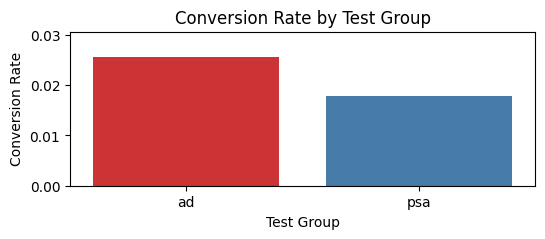

In [61]:
plt.figure(figsize=(6,2))
sns.barplot(x='test_group', y='converted', data=results, palette='Set1')
plt.title("Conversion Rate by Test Group")
plt.ylabel("Conversion Rate")
plt.xlabel("Test Group")
plt.ylim(0, results['converted'].max() * 1.2)
plt.show()

#### The conversion uplift in ad group is statistically significant.

In [65]:
# day_results = df.groupby(['test_group', 'most_ads_day']).agg({'user_id':'count', 'converted':'mean', 'total_ads':'mean'}).reset_index()
for day in df['most_ads_day'].unique():
    t_stat, p_val = ttest_ind(df[(df['most_ads_day']==day) & (df['test_group']=='ad')]['converted'], \
                              df[(df['most_ads_day']==day) & (df['test_group']=='psa')]['converted'], equal_var=False)
    print(f"{day}: t={t_stat:.3f}, p={p_val:.3f}")

Monday: t=4.132, p=0.000
Tuesday: t=6.950, p=0.000
Friday: t=2.916, p=0.004
Saturday: t=3.239, p=0.001
Wednesday: t=4.396, p=0.000
Sunday: t=1.534, p=0.125
Thursday: t=0.608, p=0.543


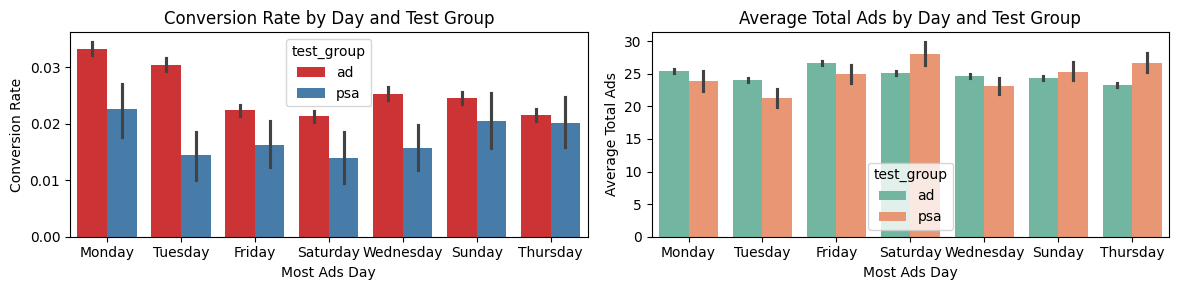

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

sns.barplot(
    x='most_ads_day', y='converted', hue='test_group',
    data=df, palette='Set1', ax=axes[0]
)
axes[0].set_title("Conversion Rate by Day and Test Group")
axes[0].set_ylabel("Conversion Rate")
axes[0].set_xlabel("Most Ads Day")

sns.barplot(
    x='most_ads_day', y='total_ads', hue='test_group',
    data=df, palette='Set2', ax=axes[1]
)
axes[1].set_title("Average Total Ads by Day and Test Group")
axes[1].set_ylabel("Average Total Ads")
axes[1].set_xlabel("Most Ads Day")

plt.tight_layout()
plt.show()

#### Conversion rate (CR) is significantly higher on Monday, Tuesday, and Wednesday in the ad group compared to the psa group, as supported by t-test results (p < 0.05 for those days). Throughout the week, the ad group consistently shows a higher CR than the psa group, even when differences are not statistically significant — suggesting that ads are more effective at driving conversions overall. Meanwhile, the average number of ads shown per user per day is very similar between groups, indicating that the ad group’s better performance is not due to showing more ads but likely due to the content or targeting of the ads themselves. This implies that the ad group is more efficient at converting users without increasing ad exposure.

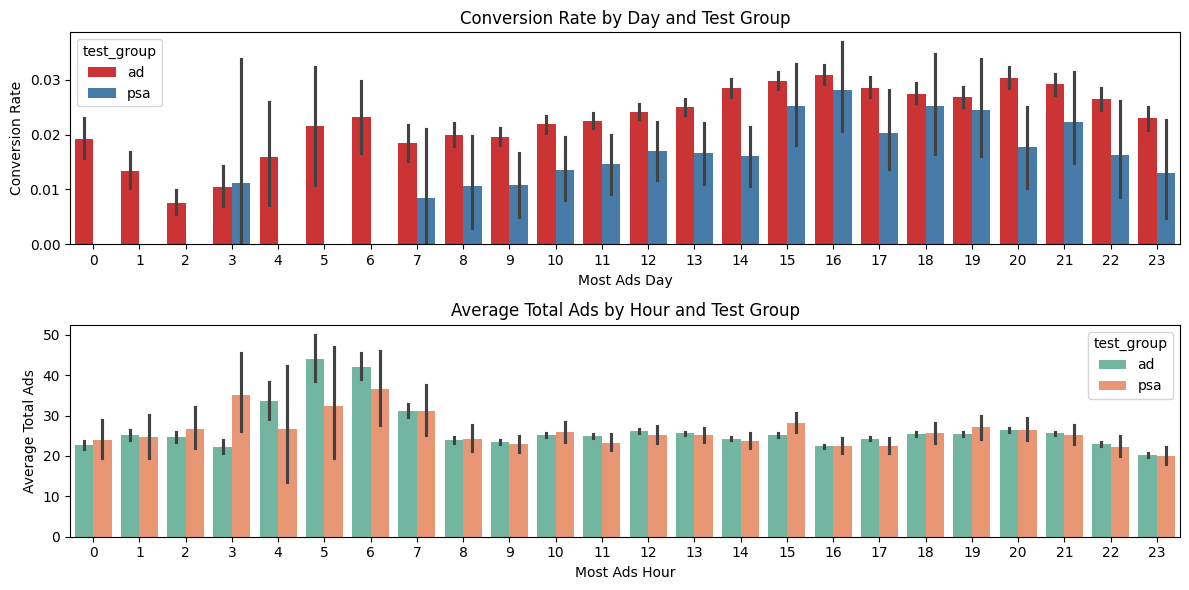

In [76]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sns.barplot(
    x='most_ads_hour', y='converted', hue='test_group',
    data=df, palette='Set1', ax=axes[0]
)
axes[0].set_title("Conversion Rate by Day and Test Group")
axes[0].set_ylabel("Conversion Rate")
axes[0].set_xlabel("Most Ads Day")

sns.barplot(
    x='most_ads_hour', y='total_ads', hue='test_group',
    data=df, palette='Set2', ax=axes[1]
)
axes[1].set_title("Average Total Ads by Hour and Test Group")
axes[1].set_ylabel("Average Total Ads")
axes[1].set_xlabel("Most Ads Hour")

plt.tight_layout()
plt.show()

#### Significant uplift in conversion rate (CR) between ~10am and 2pm. The ad group shows consistently higher CR than the psa group during late morning to early afternoon. Conversions also occur at night (midnight–6am). There are slight peaks early in the morning (4–6am) in total ads by hour.

In [106]:
bins = [0, 3, 8, 16, 29, 80, df['total_ads'].max()+1]
labels = ['1-3', '4-8', '9-16', '17-29', '30-80', '80+']

df['total_ads_segm'] = pd.cut(df['total_ads'], bins=bins, labels=labels, right=True, include_lowest=True)

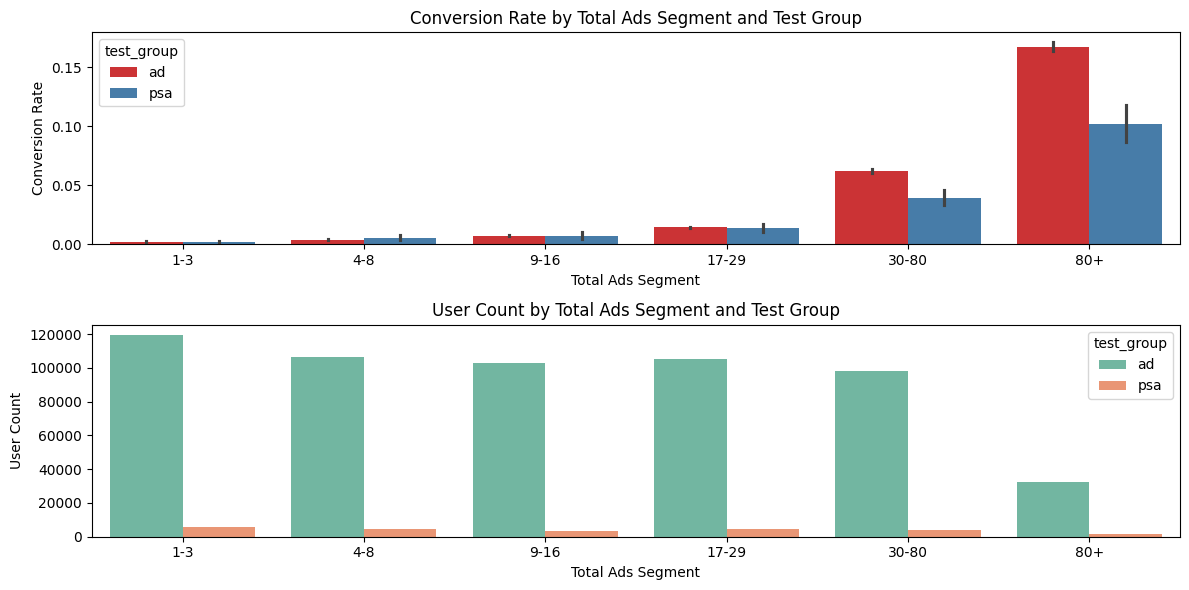

In [107]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sns.barplot(
    x='total_ads_segm', y='converted', hue='test_group',
    data=df, palette='Set1', ax=axes[0]
)
axes[0].set_title("Conversion Rate by Total Ads Segment and Test Group")
axes[0].set_ylabel("Conversion Rate")
axes[0].set_xlabel("Total Ads Segment")

user_counts = (df.groupby(['total_ads_segm', 'test_group']).size().reset_index(name='user_count'))

sns.barplot(
    x='total_ads_segm', y='user_count', hue='test_group',
    data=user_counts, palette='Set2', ax=axes[1]
)
axes[1].set_title("User Count by Total Ads Segment and Test Group")
axes[1].set_ylabel("User Count")
axes[1].set_xlabel("Total Ads Segment")

plt.tight_layout()
plt.show()

#### Users exposed to 80+ ads convert up to ~17% in the ad group, and ~10% in the psa group. This suggests that high-frequency exposure is strongly correlated with higher likelihood to convert. In segments 30+ ads, the ad group’s conversion rate is almost twice as high as the psa group, indicating the campaign is particularly effective for highly engaged users. The majority of users fall into the lower ad exposure segments (1–29 ads), but conversion rates there are minimal.

# SUMMARY

Recommendations from AB Test Analysis:

1. Users who see more ads tend to convert at higher rates, but this observation may reflect underlying engagement differences rather than a direct causal effect. Further randomized testing is needed to confirm whether increasing ad frequency directly improves conversion.

2. If supported by future experimentation, targeting already engaged users with higher-frequency ad exposure may be an efficient way to improve return on ad spend (ROAS).

3. Early-week days (Monday–Wednesday) show stronger conversion performance. While this may suggest better ad timing, it's also possible that baseline traffic quality varies by day. Nonetheless, prioritizing ad spend and testing creative variants during these days could be a promising strategy.

4. Conversion activity is highest between 10 AM and 2 PM, with a second smaller peak during late-night hours. Consider scheduling heavier ad delivery around midday, while still retaining a portion of budget for nighttime retargeting.

5. Given segment differences and observed patterns, it’s critical to continue validating all results with statistical rigor. Maintaining a control group over time is essential to detect delayed effects such as ad fatigue or diminishing returns from increased frequency.

### EXTRA (what would be helpful before test): 
#### A/A check using bootstrap - to validate randomization and that statistical testing pipeline are sound and not producing false positives due to bias, implementation errors, or wrong assumptions

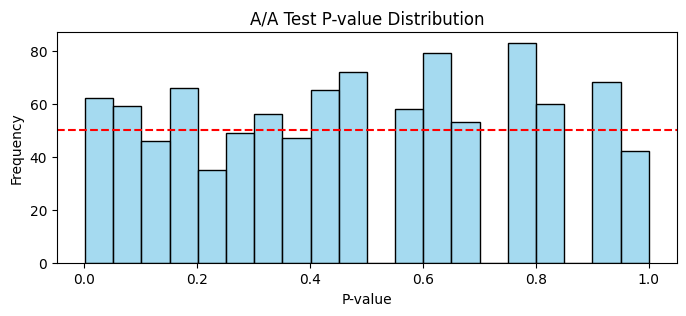

In [111]:
n_simulations = 1000
p_values = []

psa_group = df[df['test_group'] == 'psa']['converted'].astype(int).values
n = len(psa_group) // 2

for _ in range(n_simulations):
    np.random.shuffle(psa_group)
    group1 = psa_group[:n]
    group2 = psa_group[n:]
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
    p_values.append(p_val)

plt.figure(figsize=(8,3))
sns.histplot(p_values, bins=20, kde=False, color='skyblue')
plt.axhline(y=len(p_values)/20, color='red', linestyle='--')
plt.title("A/A Test P-value Distribution")
plt.xlabel("P-value")
plt.ylabel("Frequency")
plt.show()

#### MDE - How many users per group are needed to detect a 0.7% absolute uplift, with significance level α (0.05) and power 1-β (80%), considering the ration between groups 4%:96%.

In [120]:
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import NormalIndPower

p1 = 0.017854
p2 = 0.025547
alpha = 0.05
power = 0.8
ratio = 24

effect_size = proportion_effectsize(p1, p2)
analysis = NormalIndPower()
n_control = analysis.solve_power(effect_size=effect_size, nobs1=None, power=power, alpha=alpha, ratio=ratio, alternative='two-sided')

n_test = n_control * ratio
print(f"Control: {round(n_control)}, Test: {round(n_test)}, Total: {round(n_control + n_test)}")

Control: 2910, Test: 69838, Total: 72748
